In [845]:
import cv2
import numpy as np
from pathlib import Path
from IPython.display import display
from PIL import Image

In [846]:
TEST_IMG_NAME = "pics/1.jpeg"
REF_IMGS_DIR = "references2"
PAD = 10
MIN_AREA_RATIO = 0.01
ASPECT_LOW, ASPECT_HIGH = 0.25, 2.5
RECT_FILL_RATIO = 0.75
DIST_RATIO = 0.75
RESIZE_WIDTH = 400
RESIZE_HEIGHT = 300

In [847]:
ref_data = []
ref_dir  = Path(REF_IMGS_DIR)

In [848]:
img_to_process = cv2.imread(TEST_IMG_NAME)

In [849]:
sift = cv2.SIFT_create()

In [850]:
def order_clockwise(pts):
    c = np.mean(pts, axis=0)
    angles = np.arctan2(pts[:,1]-c[1], pts[:,0]-c[0])
    return pts[np.argsort(angles)]

In [851]:
def display_resized(pic, resize=1):
    h, w = pic.shape[:2]
    display(Image.fromarray(cv2.cvtColor(pic, cv2.COLOR_BGR2RGB)).resize((w // resize, h // resize), Image.LANCZOS))    

In [852]:
def scale_image(img, w, h):
    in_h, in_w = img.shape[:2]

    scale = max(w / in_w, h / in_h)

    if scale < 1.0:
        interp = cv2.INTER_AREA
    elif scale < 2.0:
        interp = cv2.INTER_CUBIC
    else:
        interp = cv2.INTER_LANCZOS4

    return cv2.resize(img, (w, h), interpolation=interp)

In [853]:
def warp_image(img, quad=None):
    if quad is None:
        h, w = img.shape[:2]
        quad = order_clockwise(np.array([[0,     0],
                                         [w - 1, 0],
                                         [w - 1, h - 1],
                                         [0,     h - 1]], dtype=np.float32))

    dist1 = np.linalg.norm(quad[1] - quad[0])
    dist2 = np.linalg.norm(quad[2] - quad[1])
    dist3 = np.linalg.norm(quad[3] - quad[2])
    dist4 = np.linalg.norm(quad[0] - quad[3])

    width  = int(round(max(dist1, dist3)))
    height = int(round(max(dist2, dist4)))

    if width < height:
        width, height = height, width
        dst = np.array([[0, 0],
                        [0, height-1],
                        [width-1, height-1],
                        [width-1, 0]], np.float32)
    else:
        dst = np.array([[0, 0],
                        [width-1, 0],
                        [width-1, height-1],
                        [0, height-1]], np.float32)

    M = cv2.getPerspectiveTransform(quad, dst)
    warped = cv2.warpPerspective(img, M, (width, height),
                                flags=cv2.INTER_LINEAR,
                                borderMode=cv2.BORDER_REPLICATE)
    
    return warped

In [854]:
def sharpen_image(img):
    kernel = np.array([[ -0.5, -1.0, -0.5],
                       [ -1.0,  7.0, -1.0],
                       [ -0.5, -1.0, -0.5]], dtype=np.float32)

    sharpened = cv2.filter2D(img, ddepth=-1, kernel=kernel, borderType=cv2.BORDER_REPLICATE)
    return sharpened

In [855]:
for file in ref_dir.rglob("*"):
    if not file.is_file():
        continue
    
    img = cv2.imread(str(file))

    if img is None:
        print(f"Error: could not read image {file}")
        continue

    warped = warp_image(img)
    sharpened = sharpen_image(warped)
    scaled = scale_image(sharpened, RESIZE_WIDTH, RESIZE_HEIGHT)
    sharpened = sharpen_image(scaled)

    #display_resized(scaled, 16)

    kp, des = sift.detectAndCompute(sharpened, None)
    ref_data.append((file, kp, des))
    print(f"{file.name:>25s}: {len(kp):4d} key-points")

               pikk_8.png:  284 key-points
               pikk_9.png:  288 key-points
               pikk_K.png: 1320 key-points
Error: could not read image references2/.DS_Store
               pikk_J.png: 1212 key-points
              treff_Q.png: 1274 key-points
               kör_K.png: 1480 key-points
               kör_J.png: 1325 key-points
              treff_3.png:  167 key-points
             káró_K.png:  965 key-points
             káró_J.png:  947 key-points
              treff_2.png:  118 key-points
              treff_6.png:  306 key-points
             káró_8.png:  214 key-points
             káró_9.png:  100 key-points
              treff_A.png:  128 key-points
              treff_7.png:  249 key-points
              treff_5.png:  226 key-points
               kör_8.png:  208 key-points
               kör_9.png:  203 key-points
              treff_4.png:  267 key-points
              treff_9.png:  281 key-points
               kör_4.png:  141 key-points
    

In [856]:
padded = cv2.copyMakeBorder(img_to_process, PAD, PAD, PAD, PAD, cv2.BORDER_CONSTANT, value=0)
blurred = cv2.GaussianBlur(padded, (11, 11), 0)

In [857]:
edges = cv2.Canny(blurred, 10, 200)

In [858]:
contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

In [859]:
h, w = img_to_process.shape[:2]
img_area = h * w

In [860]:
quads = []
all_quads = []

for c in contours:
    rect = cv2.minAreaRect(c)
    all_quads.append(cv2.boxPoints(rect))

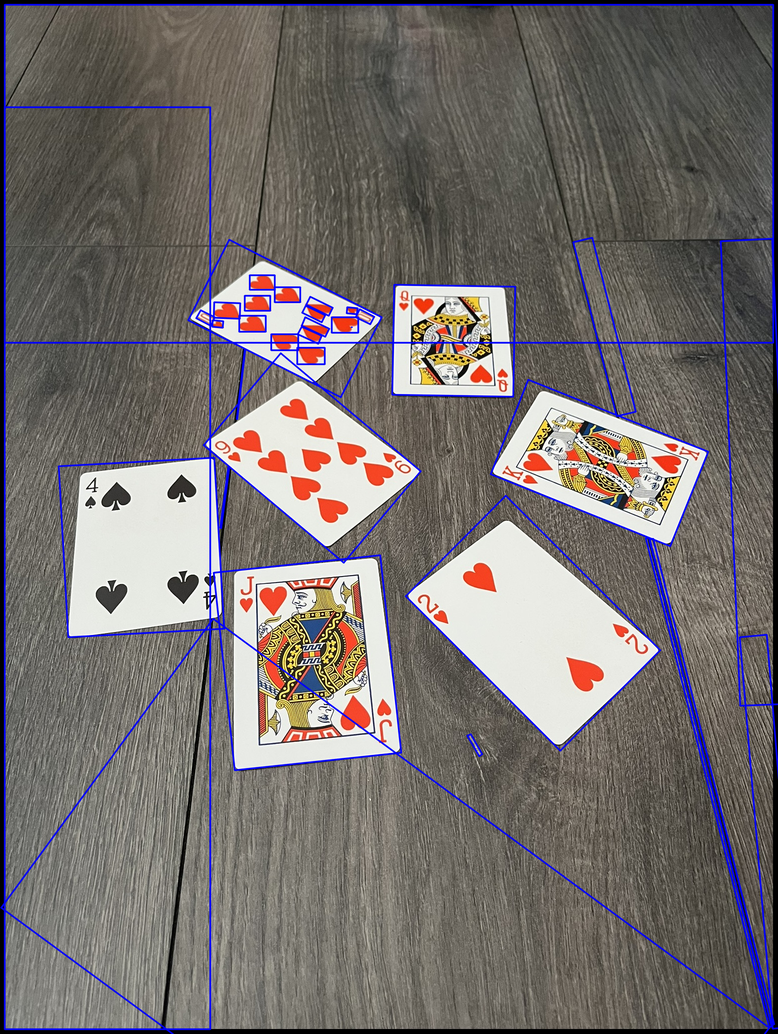

In [861]:
annotated = padded.copy()
for quad in all_quads:
    cv2.polylines(
        annotated,
        [quad.astype(np.int32)],
        isClosed=True,
        color=(255, 0, 0),
        thickness=2,
        lineType=cv2.LINE_AA
    )
display_resized(annotated, 2)

In [862]:
quads = []
quads_dropped_area_ratio = []
quads_dropped_0 = []
quads_dropped_aspect = []
quads_dropped_fill = []

for c in contours:
    rect = cv2.minAreaRect(c)
    if cv2.contourArea(c) < MIN_AREA_RATIO * img_area:
        quads_dropped_area_ratio.append(order_clockwise(cv2.boxPoints(rect)))
        continue
    (cx, cy), (rw, rh), _ = rect
    if rw == 0 or rh == 0:
        quads_dropped_0.append(order_clockwise(cv2.boxPoints(rect)))
        continue
    aspect = max(rw, rh) / min(rw, rh)
    if not ASPECT_LOW <= aspect <= ASPECT_HIGH:
        quads_dropped_aspect.append(order_clockwise(cv2.boxPoints(rect)))
        continue
    if cv2.contourArea(c) / (rw * rh) < RECT_FILL_RATIO:
        quads_dropped_fill.append(order_clockwise(cv2.boxPoints(rect)))
        continue
    quads.append(order_clockwise(cv2.boxPoints(rect)))

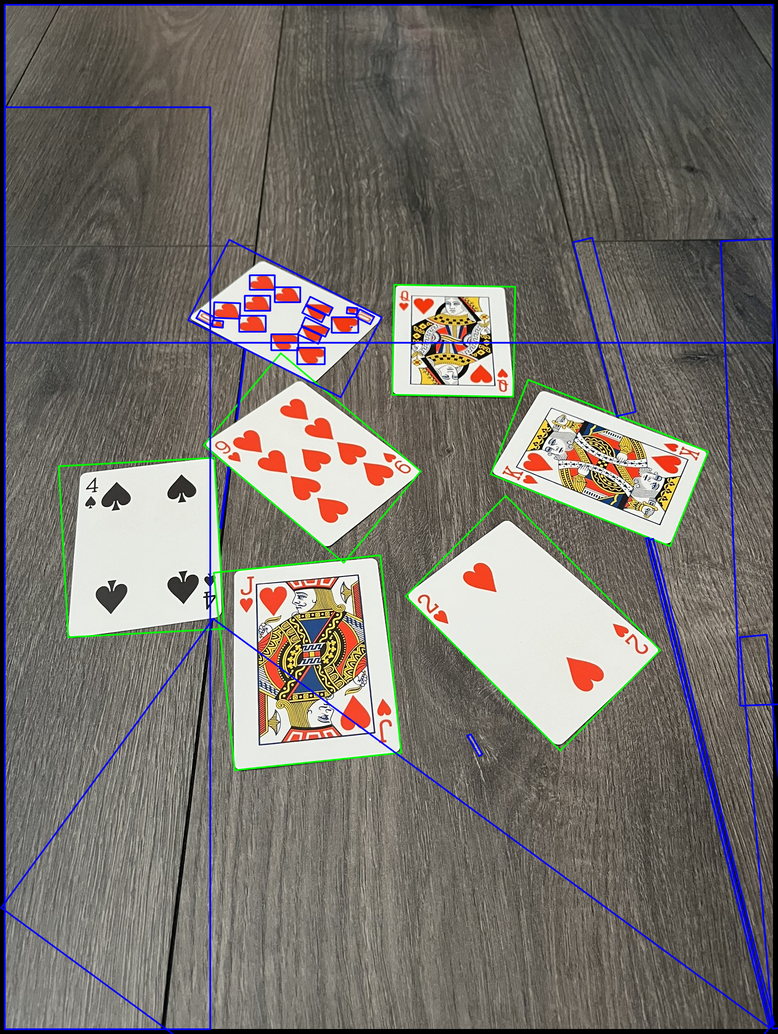

In [863]:
annotated = padded.copy()
for quad in quads:
    cv2.polylines(
        annotated,
        [quad.astype(np.int32)],
        isClosed=True,
        color=(0, 255, 0), #zold
        thickness=2,
        lineType=cv2.LINE_AA
    )
for quad in quads_dropped_area_ratio:
    cv2.polylines(
        annotated,
        [quad.astype(np.int32)],
        isClosed=True,
        color=(255, 0, 0), #kek
        thickness=2,
        lineType=cv2.LINE_AA
    )
for quad in quads_dropped_aspect:
    cv2.polylines(
        annotated,
        [quad.astype(np.int32)],
        isClosed=True,
        color=(0, 0, 255), #piros
        thickness=2,
        lineType=cv2.LINE_AA
    )
for quad in quads_dropped_fill:
    cv2.polylines(
        annotated,
        [quad.astype(np.int32)],
        isClosed=True,
        color=(255, 0, 255), #lila
        thickness=2,
        lineType=cv2.LINE_AA
    )
for quad in quads_dropped_0:
    cv2.polylines(
        annotated,
        [quad.astype(np.int32)],
        isClosed=True,
        color=(255, 255, 255), #feher
        thickness=2,
        lineType=cv2.LINE_AA
    )
display_resized(annotated, 2)

In [899]:
quads      = []
all_polys  = []

for c in contours:
    eps  = 0.02 * cv2.arcLength(c, True)
    poly = cv2.approxPolyDP(c, eps, True)

    all_polys.append(poly)

    if 4 < len(poly) <= 8:
        hull = cv2.convexHull(poly)                 # remove dents
        peri_h = cv2.arcLength(hull, True)
        poly_h = cv2.approxPolyDP(hull, 0.04 * peri_h, True)  # looser ε

        if len(poly_h) != 4:
            continue
        else:
            poly = poly_h

    if len(poly) != 4 or not cv2.isContourConvex(poly):
        continue

    area_cnt  = cv2.contourArea(c)
    quad      = poly.reshape(4, 2).astype(np.float32)
    quad      = order_clockwise(quad)
    w_top  = np.linalg.norm(quad[1] - quad[0])
    w_bot  = np.linalg.norm(quad[2] - quad[3])
    h_left = np.linalg.norm(quad[3] - quad[0])
    h_right= np.linalg.norm(quad[2] - quad[1])
    width  = max(w_top, w_bot)
    height = max(h_left, h_right)
    aspect = width / height if height else 0
    fill   = area_cnt / (width * height) if width and height else 0

    if not (ASPECT_LOW <= aspect <= ASPECT_HIGH):
        continue
 
    if cv2.contourArea(quad) < MIN_AREA_RATIO * img_area:
        continue
    
    quads.append(quad)

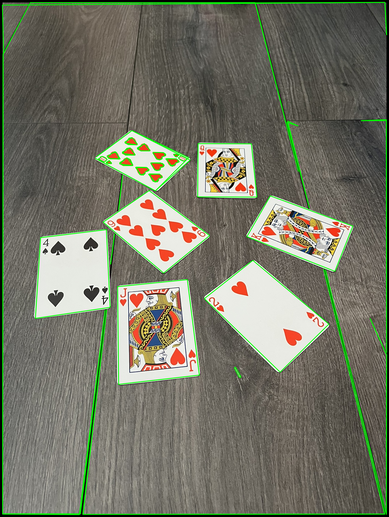

In [900]:
annotated = padded.copy()

for poly in all_polys:
    cv2.polylines(
        annotated,
        [poly.astype(np.int32)],
        isClosed=True,
        color=(0, 255, 0),
        thickness=2,
        lineType=cv2.LINE_AA
    )

display_resized(annotated, 4)

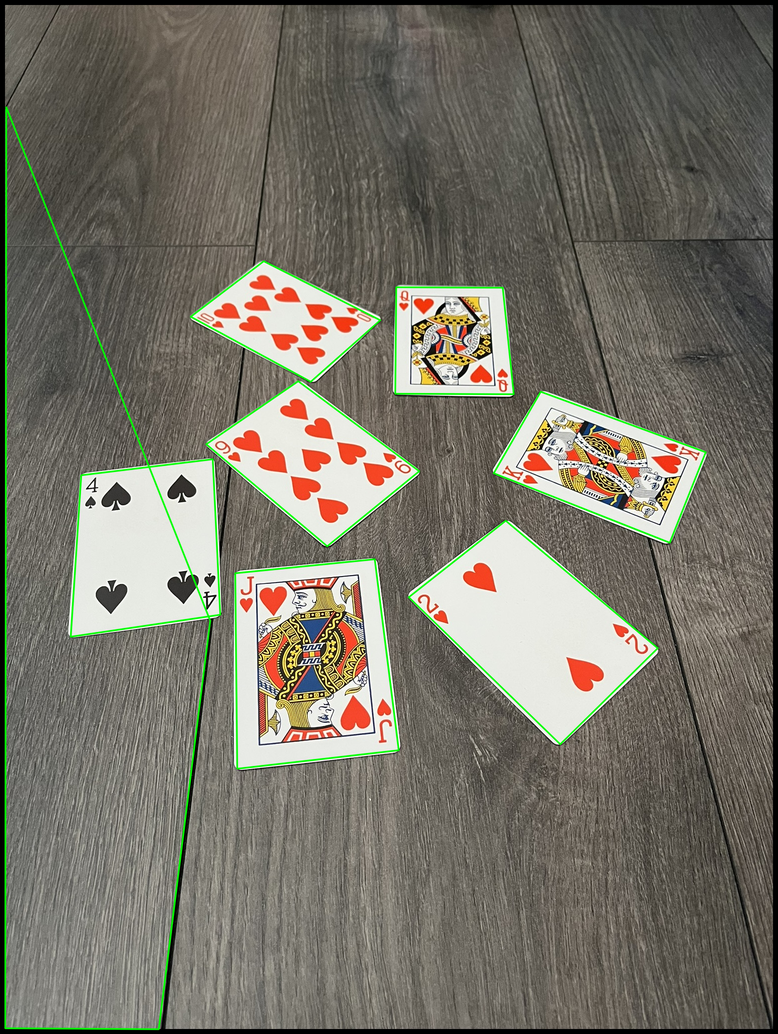

In [901]:
annotated = padded.copy()
for quad in quads:
    cv2.polylines(
        annotated,
        [quad.astype(np.int32)],
        isClosed=True,
        color=(0, 255, 0), #zold
        thickness=2,
        lineType=cv2.LINE_AA
    )
display_resized(annotated, 2)

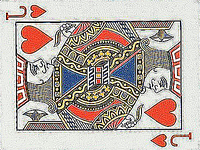

1507 key-points


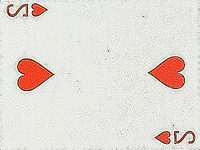

 174 key-points


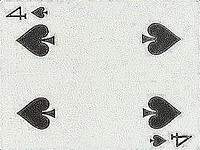

 477 key-points


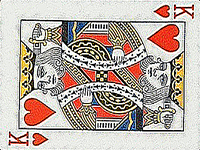

2627 key-points


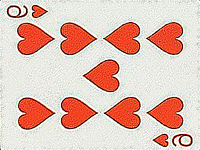

 580 key-points


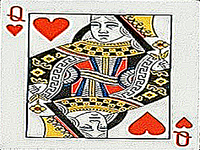

2520 key-points


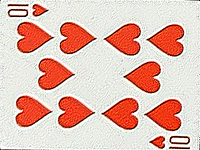

 943 key-points


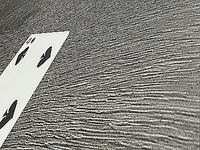

1062 key-points


In [902]:
per_card_data = []

for quad in quads:
    warped = warp_image(padded, quad)
    sharpened = sharpen_image(warped)
    scaled = scale_image(sharpened, RESIZE_WIDTH, RESIZE_HEIGHT)
    sharpened = sharpen_image(scaled)

    display_resized(sharpened, 2)

    kp, des = sift.detectAndCompute(sharpened, None)
    per_card_data.append((kp, des))
    print(f"{len(kp):4d} key-points")

In [904]:
bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=False)

In [905]:
results = []

for kp_card, des_card in per_card_data:
    best_ref, best_score = None, 0
    print(len(kp_card))

    for ref_path, kp_ref, des_ref in ref_data:
        knn = bf.knnMatch(des_card, des_ref, k=2)
        good = [m for m, n in knn if m.distance < DIST_RATIO * n.distance]
        if len(good) > best_score:
            best_ref, best_score = ref_path, len(good)
            print(f"Best match: {len(kp_ref)} {best_ref} {best_score}")

    results.append((best_ref, best_score))

1507
Best match: 284 references2/pikk_8.png 2
Best match: 288 references2/pikk_9.png 9
Best match: 1320 references2/pikk_K.png 21
Best match: 1212 references2/pikk_J.png 27
Best match: 1325 references2/kör_J.png 70
174
Best match: 284 references2/pikk_8.png 1
Best match: 288 references2/pikk_9.png 3
Best match: 1320 references2/pikk_K.png 7
Best match: 88 references2/káró_5.png 11
477
Best match: 284 references2/pikk_8.png 15
Best match: 288 references2/pikk_9.png 18
Best match: 167 references2/treff_3.png 22
Best match: 118 references2/treff_2.png 26
Best match: 1467 references2/treff_J.png 27
Best match: 191 references2/pikk_4.png 28
2627
Best match: 284 references2/pikk_8.png 11
Best match: 288 references2/pikk_9.png 21
Best match: 1320 references2/pikk_K.png 57
Best match: 1480 references2/kör_K.png 363
580
Best match: 284 references2/pikk_8.png 14
Best match: 288 references2/pikk_9.png 31
Best match: 1320 references2/pikk_K.png 35
Best match: 80 references2/kör_A.png 46
2520


In [906]:
for i, (ref_path, score) in enumerate(results):
    if ref_path is None:
        print(f"Card {i}: no reasonable match")
    else:
        print(f"Card {i}: best match → {ref_path.name}  ({score} good matches)")

print(f"Detected {len(quads)} card(s) and {sum(len(k) for k,_ in per_card_data)} SIFT key-points.")

Card 0: best match → kör_J.png  (70 good matches)
Card 1: best match → káró_5.png  (11 good matches)
Card 2: best match → pikk_4.png  (28 good matches)
Card 3: best match → kör_K.png  (363 good matches)
Card 4: best match → kör_A.png  (46 good matches)
Card 5: best match → káró_7.png  (64 good matches)
Card 6: best match → treff_10.png  (88 good matches)
Card 7: best match → káró_7.png  (39 good matches)
Detected 8 card(s) and 9890 SIFT key-points.
